In [9]:
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("../data/curated/listings_w_stations.csv")
school = pd.read_csv("../data/curated/Closest_and_average_dist_school.csv")

In [3]:
data = pd.merge(data,school,left_on='id',right_on='listing_id')

In [4]:
data = data[["price", "beds","propertyType", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestDstToStation", "dist_closest_school","ave_dist_3_schools"]]
bed_4_house = data[(data["beds"] == 4) & (data["propertyType"] == "House")]
bed_3_house = data[(data["beds"] == 3) & (data["propertyType"] == "House")]
bed_2_house = data[(data["beds"] == 2) & (data["propertyType"] == "House")]
bed_3_flat = data[(data["beds"] == 3) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_2_flat = data[(data["beds"] == 2) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_1_flat = data[(data["beds"] == 1) & (data["propertyType"] == "Apartment / Unit / Flat")]

In [19]:
data["propertyType"].value_counts()

House                      6025
Apartment / Unit / Flat    4579
Townhouse                  1300
Studio                       85
Villa                        34
Acreage / Semi-Rural         11
Terrace                       9
Semi-Detached                 6
Duplex                        5
Penthouse                     1
Rural                         1
Name: propertyType, dtype: int64

<AxesSubplot:>

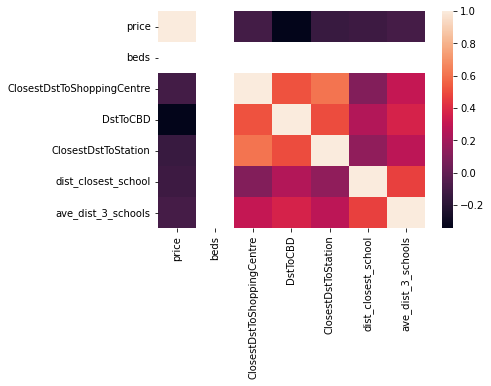

In [10]:
bed_2_flat.corr()
sns.heatmap(bed_2_flat.corr())

In [7]:
bed_3_flat.corr()

,price,beds,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,dist_closest_school,ave_dist_3_schools
price,1.000000,NaN,-0.129312,-0.346250,-0.088271,-0.046727,-0.073292
beds,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClosestDstToShoppingCentre,-0.129312,NaN,1.000000,0.488608,0.403832,0.124804,0.174479
DstToCBD,-0.346250,NaN,0.488608,1.000000,0.424605,0.204071,0.267060
ClosestDstToStation,-0.088271,NaN,0.403832,0.424605,1.000000,0.093007,0.145424
dist_closest_school,-0.046727,NaN,0.124804,0.204071,0.093007,1.000000,0.892861
ave_dist_3_schools,-0.073292,NaN,0.174479,0.267060,0.145424,0.892861,1.000000


In [8]:
bed_1_flat.corr()

,price,beds,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,dist_closest_school,ave_dist_3_schools
price,1.000000,NaN,-0.088390,-0.250697,-0.116094,-0.044029,-0.073791
beds,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClosestDstToShoppingCentre,-0.088390,NaN,1.000000,0.496866,0.692815,0.086381,0.223033
DstToCBD,-0.250697,NaN,0.496866,1.000000,0.474382,0.218202,0.318808
ClosestDstToStation,-0.116094,NaN,0.692815,0.474382,1.000000,0.085067,0.235503
dist_closest_school,-0.044029,NaN,0.086381,0.218202,0.085067,1.000000,0.660080
ave_dist_3_schools,-0.073791,NaN,0.223033,0.318808,0.235503,0.660080,1.000000


In [5]:
bed_2_house.corr()

,price,beds,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,dist_closest_school,ave_dist_3_schools
price,1.000000,NaN,-0.238733,-0.542264,-0.244015,-0.150794,-0.142424
beds,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClosestDstToShoppingCentre,-0.238733,NaN,1.000000,0.518567,0.575404,0.190929,0.392212
DstToCBD,-0.542264,NaN,0.518567,1.000000,0.517541,0.248603,0.369877
ClosestDstToStation,-0.244015,NaN,0.575404,0.517541,1.000000,0.183247,0.336990
dist_closest_school,-0.150794,NaN,0.190929,0.248603,0.183247,1.000000,0.512396
ave_dist_3_schools,-0.142424,NaN,0.392212,0.369877,0.336990,0.512396,1.000000
